In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from functions import all_models as m
from functions import plot_importances

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


In [2]:
df = pd.read_csv('data/Tweets.csv')

In [3]:
df.drop(inplace = True, columns=['tweet_coord', 'tweet_location', 'user_timezone', 'tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline_sentiment_gold', 'negativereason_gold'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   airline            14640 non-null  object
 2   name               14640 non-null  object
 3   retweet_count      14640 non-null  int64 
 4   text               14640 non-null  object
 5   tweet_created      14640 non-null  object
dtypes: int64(1), object(5)
memory usage: 686.4+ KB


In [10]:
stop_words = stopwords.words('english')

def process(tweet):
    
    lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'[@a-zA-Z0-9]+')
    
    tweet = tweet.lower()
    tweet = tokenizer.tokenize(tweet)
    tweet = [w for w in tweet if w not in stop_words]
    tweet = [lemmatizer.lemmatize(w) for w in tweet]
    tweet = ' '.join(tweet)
    
    return tweet

In [11]:
vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern='[a-zA-Z0-9]+')

In [12]:
x = df['text'].apply(process)
y = df['airline_sentiment']

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=16)

In [14]:
x_train

7322     @jetblue heard new flight tap pay reader accep...
13249    @americanair @usairways complaint visit custom...
3738     @united 20 min departure one waiting pressed g...
14223    @americanair full flight customer sitting plan...
7226     @jetblue great see redsox plane reminder ny si...
                               ...                        
635      @united finger crossed amp intact disappointed...
1345     @united first complaint filed feb 11th 10 day ...
581      @united thnx quick reply think assist intl grp...
2169                 @united trip get another airline home
6825                      @jetblue wish everyone felt like
Name: text, Length: 10980, dtype: object

In [15]:
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [16]:
objects = [LogisticRegression(fit_intercept=False, C=1e12), 
           MultinomialNB(),
           DecisionTreeClassifier(), 
           RandomForestClassifier(), 
           XGBClassifier()]
index = ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost']

Logistic Regression Results:


C:\Users\ferra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


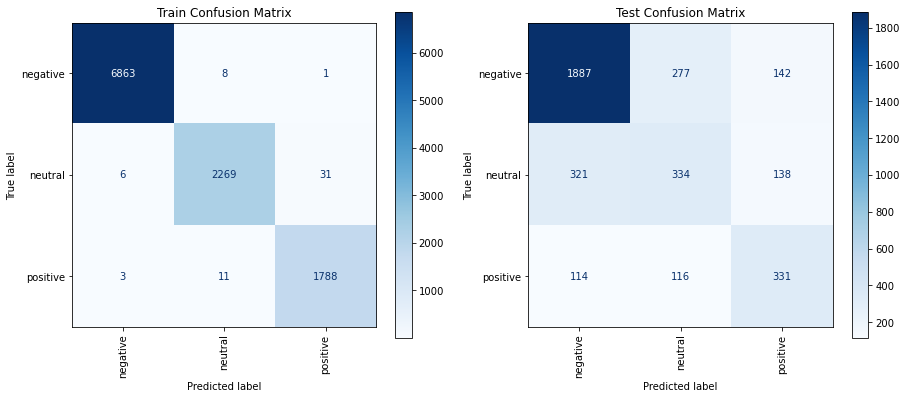

              precision    recall  f1-score   support

    negative       0.81      0.82      0.82      2306
     neutral       0.46      0.42      0.44       793
    positive       0.54      0.59      0.56       561

    accuracy                           0.70      3660
   macro avg       0.60      0.61      0.61      3660
weighted avg       0.69      0.70      0.70      3660



Naive Bayes Results:


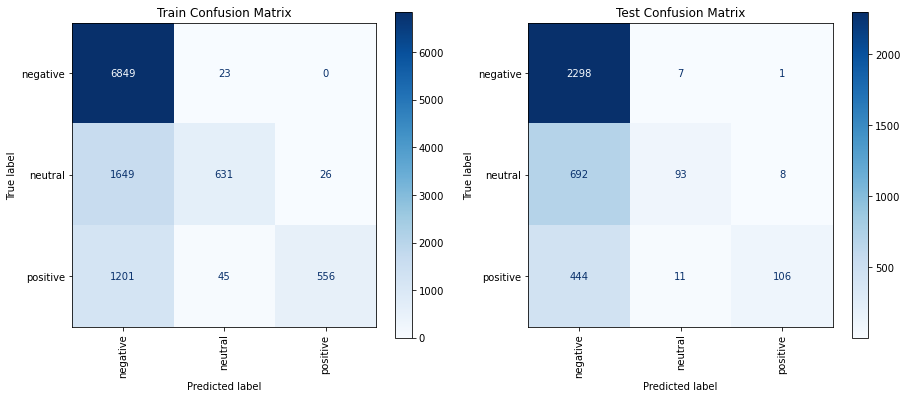

              precision    recall  f1-score   support

    negative       0.67      1.00      0.80      2306
     neutral       0.84      0.12      0.21       793
    positive       0.92      0.19      0.31       561

    accuracy                           0.68      3660
   macro avg       0.81      0.43      0.44      3660
weighted avg       0.74      0.68      0.60      3660



Decision Tree Results:


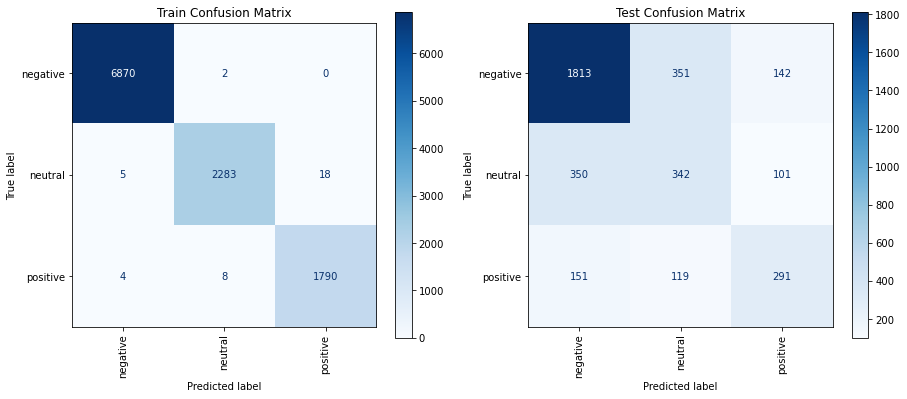

              precision    recall  f1-score   support

    negative       0.78      0.79      0.78      2306
     neutral       0.42      0.43      0.43       793
    positive       0.54      0.52      0.53       561

    accuracy                           0.67      3660
   macro avg       0.58      0.58      0.58      3660
weighted avg       0.67      0.67      0.67      3660



Random Forest Results:


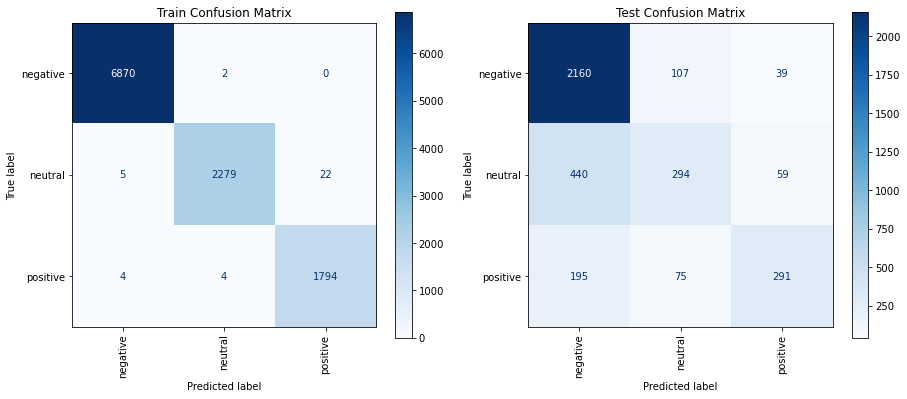

              precision    recall  f1-score   support

    negative       0.77      0.94      0.85      2306
     neutral       0.62      0.37      0.46       793
    positive       0.75      0.52      0.61       561

    accuracy                           0.75      3660
   macro avg       0.71      0.61      0.64      3660
weighted avg       0.74      0.75      0.73      3660



XGBoost Results:


C:\Users\ferra\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:54:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


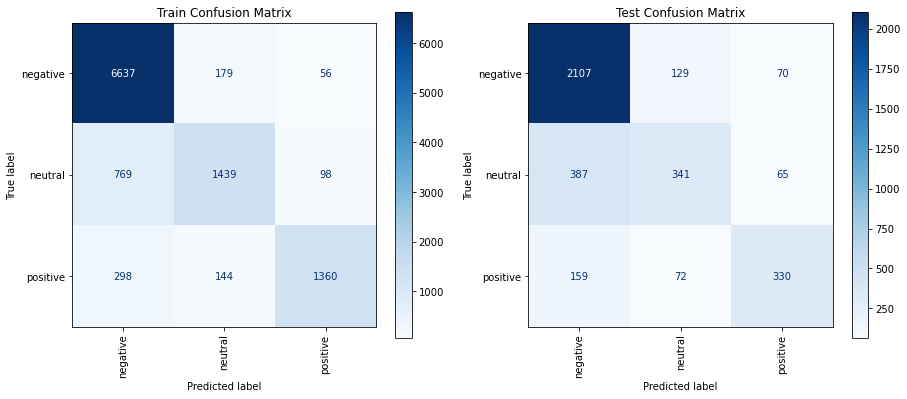

              precision    recall  f1-score   support

    negative       0.79      0.91      0.85      2306
     neutral       0.63      0.43      0.51       793
    positive       0.71      0.59      0.64       561

    accuracy                           0.76      3660
   macro avg       0.71      0.64      0.67      3660
weighted avg       0.75      0.76      0.74      3660





,Precision Score,Recall Score,Accuracy Score,F1 Score
Logistic Regression,60.46%,60.98%,69.73%,60.66%
Naive Bayes,80.96%,43.43%,68.22%,44.00%
Decision Tree,58.32%,57.87%,66.83%,58.08%
Random Forest,71.28%,60.87%,75.00%,64.10%
XGBoost,71.10%,64.40%,75.90%,66.80%


The model with the highest precision score is Naive Bayes.
The model with the highest recall score is XGBoost.
The model with the highest accuracy score is XGBoost.
The model with the highest F1 score is XGBoost.


In [13]:
models = m(x_train, x_test, y_train, y_test, objects=objects, index=index)

In [41]:
importances = sorted(list(zip(models[4].feature_importances_, vectorizer.get_feature_names())))[-20:]
impts = pd.DataFrame(importances, columns=['impt', 'feat'])

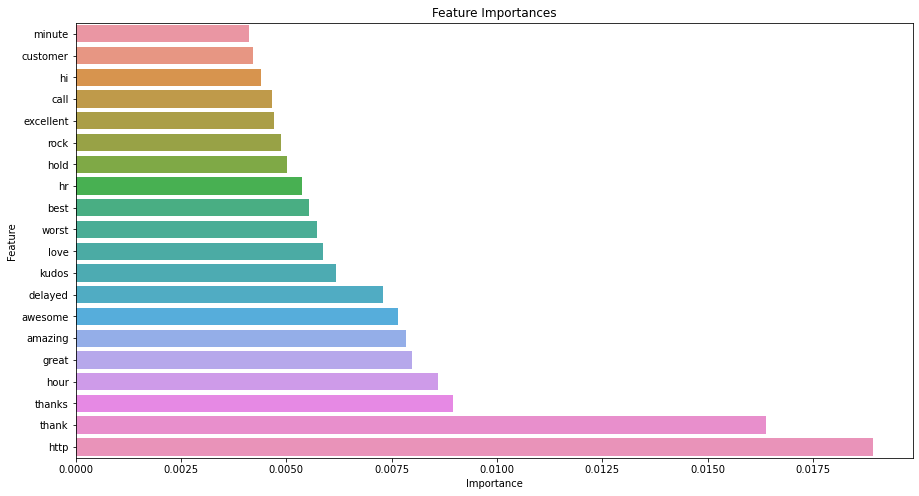

In [38]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=impts, y='feat', x='impt')
ax.set_title('Feature Importances')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
plt.show();

In [17]:
from imblearn.over_sampling import SMOTE

In [18]:
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

Logistic Regression Results:


C:\Users\ferra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


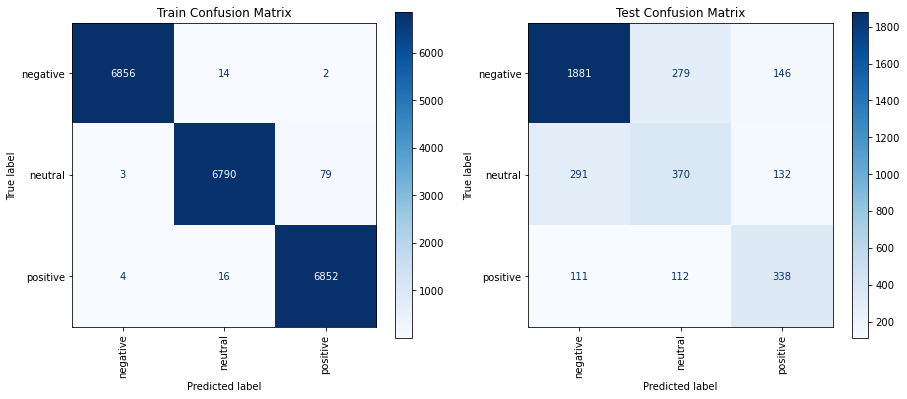

              precision    recall  f1-score   support

    negative       0.82      0.82      0.82      2306
     neutral       0.49      0.47      0.48       793
    positive       0.55      0.60      0.57       561

    accuracy                           0.71      3660
   macro avg       0.62      0.63      0.62      3660
weighted avg       0.71      0.71      0.71      3660



Naive Bayes Results:


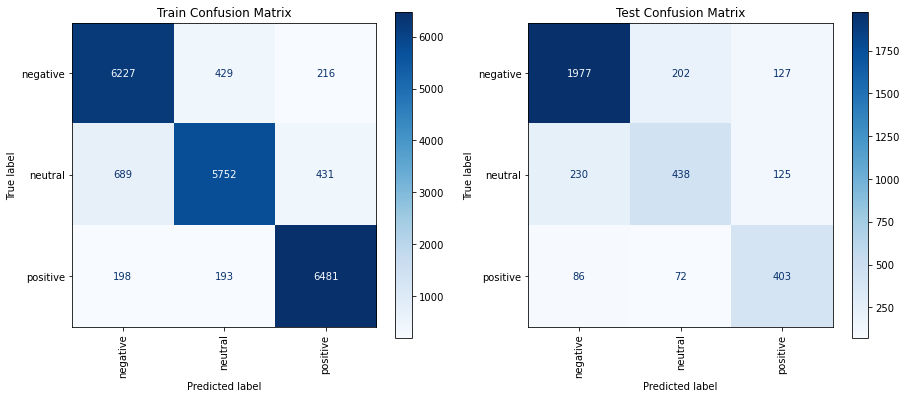

              precision    recall  f1-score   support

    negative       0.86      0.86      0.86      2306
     neutral       0.62      0.55      0.58       793
    positive       0.62      0.72      0.66       561

    accuracy                           0.77      3660
   macro avg       0.70      0.71      0.70      3660
weighted avg       0.77      0.77      0.77      3660



Decision Tree Results:


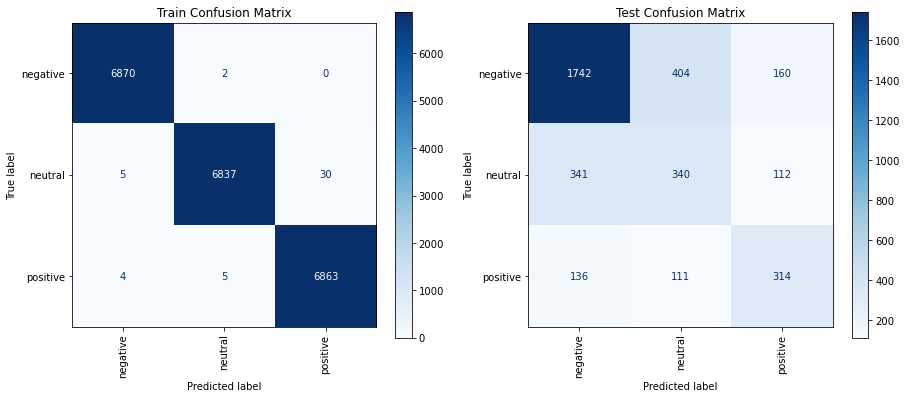

              precision    recall  f1-score   support

    negative       0.79      0.76      0.77      2306
     neutral       0.40      0.43      0.41       793
    positive       0.54      0.56      0.55       561

    accuracy                           0.65      3660
   macro avg       0.57      0.58      0.58      3660
weighted avg       0.66      0.65      0.66      3660



Random Forest Results:


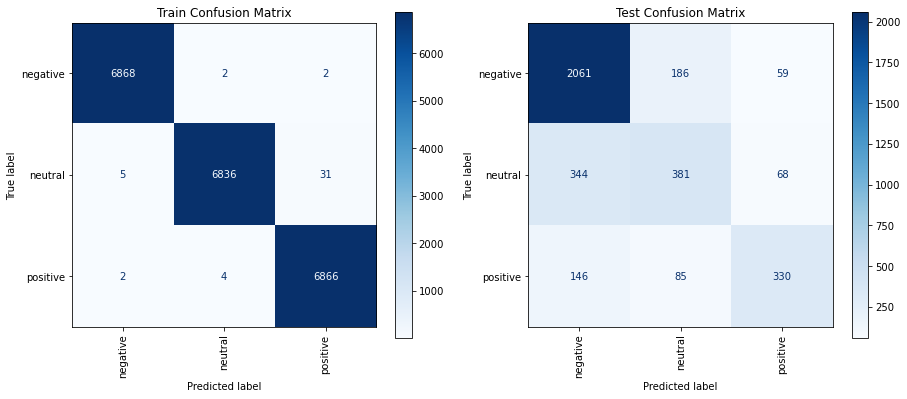

              precision    recall  f1-score   support

    negative       0.81      0.89      0.85      2306
     neutral       0.58      0.48      0.53       793
    positive       0.72      0.59      0.65       561

    accuracy                           0.76      3660
   macro avg       0.70      0.65      0.67      3660
weighted avg       0.75      0.76      0.75      3660



XGBoost Results:


C:\Users\ferra\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:40:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


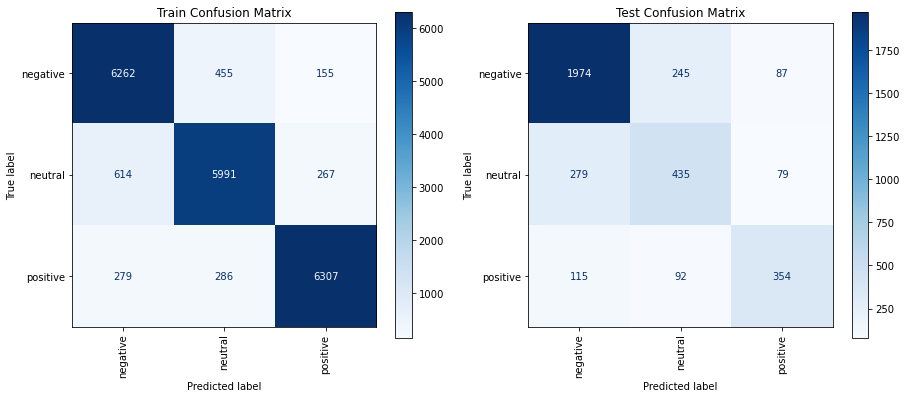

              precision    recall  f1-score   support

    negative       0.83      0.86      0.84      2306
     neutral       0.56      0.55      0.56       793
    positive       0.68      0.63      0.65       561

    accuracy                           0.75      3660
   macro avg       0.69      0.68      0.69      3660
weighted avg       0.75      0.75      0.75      3660





,Precision Score,Recall Score,Accuracy Score,F1 Score
Logistic Regression,61.96%,62.83%,70.74%,62.34%
Naive Bayes,69.75%,70.93%,76.99%,70.15%
Decision Tree,57.28%,58.13%,65.46%,57.67%
Random Forest,70.48%,65.41%,75.74%,67.48%
XGBoost,69.26%,67.85%,75.49%,68.52%


The model with the highest precision score is Random Forest.
The model with the highest recall score is Naive Bayes.
The model with the highest accuracy score is Naive Bayes.
The model with the highest F1 score is Naive Bayes.


In [19]:
models = m(x_train_smote, x_test, y_train_smote, y_test, objects=objects, index=index)